In [2]:
import mlflow
import optuna
import joblib
import warnings
import pandas as pd
import ml_insights as mli
import category_encoders as ce
import matplotlib.pyplot as plt

# Preprocessamento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures

# Modelos
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metricas
from sklearn.metrics import log_loss

# Ignora warnings
warnings.filterwarnings('ignore')


# Exploração dos dados

Nesta sessão, irei explorar os dados para entender melhor o que está por trás e
decidir como a parte de experimentação será realizada. 

## Impressões iniciais

Nesta etapa irei observar os dados de forma superficial para entender como estão
estruturados e quais informações estão disponíveis.

In [2]:
# importando os dados
dados = pd.read_csv('../data/raw/customer_booking.csv', encoding='latin-1')

In [3]:
# Checando como os dados estão
dados.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [4]:
# Verificando o tamanho do dataset
dados.shape

(50000, 14)

In [5]:
# Verificando a info sobre os dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [6]:
# Verificando se há valores duplicados
dados.drop_duplicates().shape

(49281, 14)

## Considerações a partir da análise inicial

A partir das informações iniciais, podemos entender que temos um dataset com 50 
mil registros e 14 colunas, onde tais registros não estão atribuídos a um 
usuário em específico. Devido a essa condição, podemos observar dados duplicados.

Além disso, podemos perceber que o tipo de dado da maior parte das colunas está 
coerente com o seu conteúdo, com exceção das colunas **wants_extra_baggage**, 
**wants_preferred_seat** e **wants_in_flight_meals**, que são colunas 
categóricas que foram previamente codificadas. 

Por último, também é possível perceber que não existem valores ausentes.

O nosso target está na coluna **booking complete**.

## Aplicando correções iniciais

Nesta etapa, irei apenas excluir os dados duplicados. Também será realizada a 
correção no tipo dos dados.

In [7]:
# Dropando dados duplicados
dados = dados.drop_duplicates()

In [8]:
# Alterando o tipo de dado da coluna 'wants_extra_baggage'
dados['wants_extra_baggage'] = dados['wants_extra_baggage'].astype('object')

In [9]:
# Alterando o tipo de dado da coluna 'wants_preferred_seat'
dados['wants_preferred_seat'] = dados['wants_preferred_seat'].astype('object')

In [10]:
# Alterando o tipo de dado da coluna 'wants_in_flight_meals'
dados['wants_in_flight_meals'] = dados['wants_in_flight_meals'].astype('object')

## Explorando as variáveis categóricas
Nesta etapa, irei verificar se existem valores raros em cada coluna. Caso 
existam, será necessário uni-los em uma única categoria, pois valores raros
podem compremeter o treinamento do modelo.

In [11]:
# Obtendo as colunas categóricas
cat_cols = dados.select_dtypes(include='object').columns.tolist()

In [12]:
# Verificando as colunas categóricas
dados.loc[:, cat_cols].head()

,sales_channel,trip_type,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals
0,Internet,RoundTrip,Sat,AKLDEL,New Zealand,1,0,0
1,Internet,RoundTrip,Sat,AKLDEL,New Zealand,0,0,0
2,Internet,RoundTrip,Wed,AKLDEL,India,1,1,0
3,Internet,RoundTrip,Sat,AKLDEL,New Zealand,0,0,1
4,Internet,RoundTrip,Wed,AKLDEL,India,1,0,1


In [13]:
# Verificando se existem registros raros na coluna 'sales_channel'
dados['sales_channel'].value_counts()

sales_channel
Internet    43917
Mobile       5364
Name: count, dtype: int64

In [14]:
# Verificando se existem registros raros na coluna 'trip_type'
dados['trip_type'].value_counts()

trip_type
RoundTrip     48779
OneWay          386
CircleTrip      116
Name: count, dtype: int64

In [15]:
# Verificando se existem registros raros na coluna 'flight_day'
dados['flight_day'].value_counts()


flight_day
Mon    7988
Wed    7562
Tue    7558
Thu    7323
Fri    6685
Sun    6442
Sat    5723
Name: count, dtype: int64

In [16]:
# Verificando se existem registros raros na coluna 'route'
dados['route'].value_counts()

route
AKLKUL    2620
PENTPE     912
MELSGN     833
ICNSIN     793
DMKKIX     729
          ... 
DACPEK       1
CKGSGN       1
BBIMEL       1
AKLHGH       1
MRUXIY       1
Name: count, Length: 799, dtype: int64

In [17]:
# Verificando se existem registros raros na coluna 'booking_origin'
dados['booking_origin'].value_counts()

booking_origin
Australia      17691
Malaysia        7055
South Korea     4502
Japan           3819
China           3284
               ...  
Estonia            1
Afghanistan        1
Czechia            1
Malta              1
Vanuatu            1
Name: count, Length: 104, dtype: int64

In [18]:
# Verificando se existem registros raros na coluna 'wants_extra_baggage'
dados['wants_extra_baggage'].value_counts()

wants_extra_baggage
1    32931
0    16350
Name: count, dtype: int64

In [19]:
# Verificando se existem registros raros na coluna 'wants_preferred_seat'
dados['wants_preferred_seat'].value_counts()

wants_preferred_seat
0    34712
1    14569
Name: count, dtype: int64

In [20]:
# Verificando se existem registros raros na coluna 'wants_in_flight_meals'
dados['wants_in_flight_meals'].value_counts()

wants_in_flight_meals
0    28256
1    21025
Name: count, dtype: int64

## Considerações a partir da análise das variáveis categóricas
A partir das 6 colunas categóricas, podemos observar que existem valores raros
em duas delas: **route** e **booking_origin**. Portanto, irei agrupar os valores
raros em uma nova categoria. Tais categorias serão agrupadas em uma única de nome
**'others'**. Além disso, ainda é possível observar que essas features possuem 
uma alta cardinalidade, o que pode ser um problema para o treinamento do modelo.

## Corrigindo as variáveis categóricas que apresentaram problemas
Nesta fase, os dados com menos de 4 registros serão agrupados em uma nova 
categoria.

### Booking origin

In [21]:
# Buscando os registros que atendem ao critério de raridade
country_booking_less_than_four = dados['booking_origin'].value_counts() < 8

In [22]:
# Salvando em uma lista os paises que atendem ao critério de raridade
countries = dados['booking_origin'].value_counts()[country_booking_less_than_four].index.to_list()

In [23]:
# Criando função para substituir os registros raros por 'other'
func_rare_registry = lambda country: 'other' if country in countries else country

In [24]:
# Aplicando a função
dados['booking_origin'] = dados['booking_origin'].apply(func_rare_registry)

### Route

In [25]:
# Buscando os registros que atendem ao critério de raridade
route_less_than_four = dados['route'].value_counts() < 8

In [26]:
# Salvando em uma lista os paises que atendem ao critério de raridade
routes = dados['route'].value_counts()[route_less_than_four].index.to_list()

In [27]:
# Criando função para substituir os registros raros por 'other'
func_rare_registry = lambda route: 'other' if route in routes else route

In [28]:
# Aplicando a função
dados['route'] = dados['route'].apply(func_rare_registry)

## Explorando as variáveis numéricas
Na segunda parte, irei observar as variáveis numéricas para entender a 
variabilidade dos dados e se existem outliers.


In [29]:
# Obtendo as colunas numéricas
num_cols = dados.select_dtypes(['int', 'float']).columns.tolist()

In [30]:
# Verificando os dados numéricos
dados.loc[:, num_cols].head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_duration,booking_complete
0,2,262,19,7,5.52,0
1,1,112,20,3,5.52,0
2,2,243,22,17,5.52,0
3,1,96,31,4,5.52,0
4,2,68,22,15,5.52,0


<Axes: >

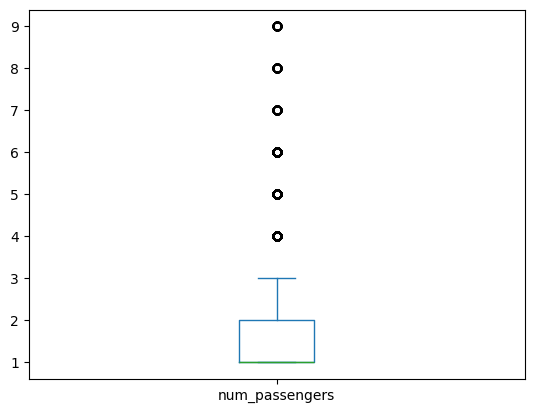

In [31]:
# Verificando a distribuição dos dados da coluna 'num_passengers'
dados['num_passengers'].plot(kind='box')

<Axes: >

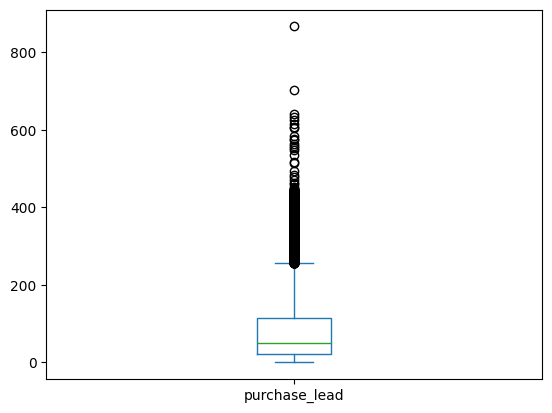

In [32]:
# Verificando a distribuição dos dados da coluna 'purchase_lead'
dados['purchase_lead'].plot(kind='box')

<Axes: >

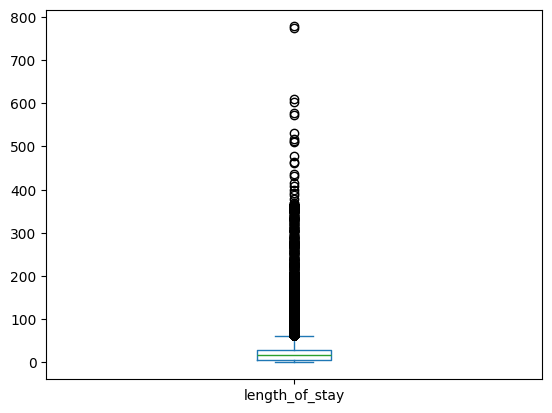

In [33]:
# Verificando a distribuição dos dados da coluna 'length_of_stay'
dados['length_of_stay'].plot(kind='box')

<Axes: >

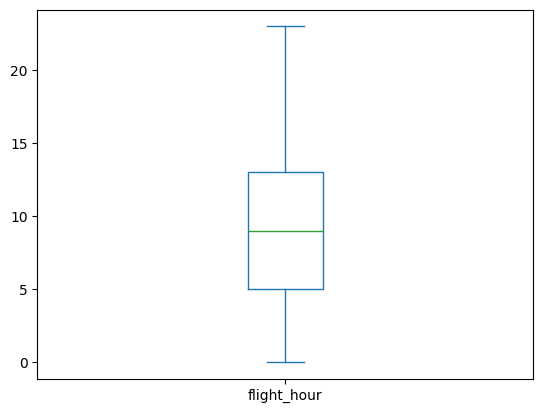

In [34]:
# Verificando a distribuição dos dados da coluna 'flight_hour'
dados['flight_hour'].plot(kind='box')

<Axes: >

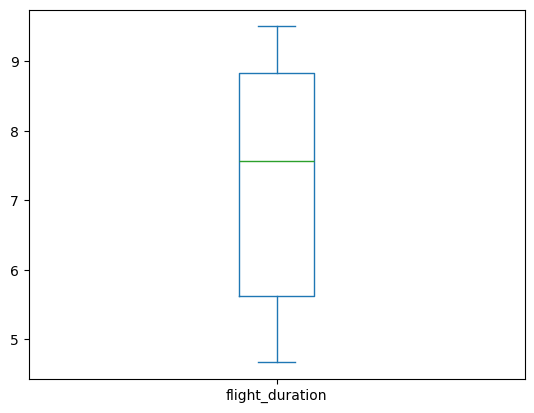

In [35]:
# Verificando a distribuição dos dados da coluna 'flight_duration'
dados['flight_duration'].plot(kind='box')

## Considerações a partir da análise das variáveis numéricas
A partir das colunas examinadas, podemos observar que existem outliers em três
delas. Entretanto, tais outliers aparentam ser naturais, e não provenientes de
erros de digitação ou de coleta de dados. Portanto, não serão tratados.

Além disso, os dados apresentam uma variabilidade considerável, fazendo com
não seja necessário realizar nenhum tipo de exclusão de coluna.



## Explorando o target
E por último, o target será analisado para verificar se há desbalanceamento.

In [36]:
dados['booking_complete'].value_counts()

booking_complete
0    41890
1     7391
Name: count, dtype: int64

## Considerações a partir da análise do target

A partir da análise do target, podemos observar que o dataset está desbalanceado.

## Criando novas features

Nesta fase, irei criar novas features a partir das variáveis existentes.

In [37]:
# Criando função para determinar em que parte do dia o voo ocorre
func_time_of_day = lambda hour: 'morning' if hour >= 6 and hour < 12 else ('afternoon' if hour >= 12 and hour < 18 else 'night')

# Aplicando a função
dados['time_of_day'] = dados['flight_hour'].apply(func_time_of_day)

In [38]:
# Calculando a hora de chegada
dados['arrival_hour'] = dados['flight_hour'] + dados['flight_duration']

In [39]:
# Criando função para verificar se o voo chega no mesmo dia
func_same_day = lambda hour: 'yes' if hour <= 24 else 'no'

# Aplicando a função
dados['same_day_arrival'] = dados['arrival_hour'].apply(func_same_day)

In [40]:
# Criando função para checar se a viagem vai ocorrer no final de semana
func_weekend = lambda day: 'yes' if day == 'Sat' or day == 'Sun' else 'no'

# Aplicando a função
dados['weekend_trip'] = dados['flight_day'].apply(func_weekend)

In [41]:
# Calculando o tempo de estadia em meses
dados['length_of_stay_months'] = dados['length_of_stay'] / 30

# calculando o tempo de estadia em semanas
dados['length_of_stay_years'] = dados['length_of_stay'] / 360

In [42]:
# Calculando a quantidade total de benefícios solicitados
dados['total_benefits'] = dados['wants_extra_baggage'] + dados['wants_preferred_seat'] + dados['wants_in_flight_meals']


In [43]:
# Calculando o lead por passageiro
dados['lead_per_passenger'] = dados['purchase_lead'] / dados['num_passengers']

In [44]:
# Criando listas com os países de cada continente
# Aqui vai uma consideração: embora a maior parte do território da Rússia esteja
# localizada na Ásia, a maior parte da população está localizada na Europa, por
# isso a Rússia está na lista de países europeus.

america = ["Canada", "United States", "Mexico", "Brazil", "Argentina", 
           "Colombia", "Peru", "Venezuela", "Chile", "Ecuador", "Bolivia", 
           "Paraguay", "Uruguay", "Guyana", "Suriname", "French Guiana", 
           "Guatemala", "Honduras", "El Salvador", "Nicaragua", "Costa Rica", 
           "Panama", "Cuba", "Jamaica", "Haiti", "Dominican Republic", 
           "Puerto Rico", "Bahamas", "Trinidad and Tobago", "Barbados", 
           "Grenada", "Saint Vincent and the Grenadines", "Saint Lucia", 
           "Antigua and Barbuda", "Saint Kitts and Nevis", "Belize", 
           "Guadeloupe", "Martinique", "Aruba", "Curacao", "Bonaire", 
           "Sint Eustatius", "Saba", "Turks and Caicos Islands", 
           "Cayman Islands", "British Virgin Islands", 
           "United States Virgin Islands", "Montserrat", "Anguilla", 
           "Saint Pierre and Miquelon", "Greenland", "Bermuda"]

asia = ["China", "India", "Indonesia", "Pakistan", "Bangladesh", 
        "Japan", "Philippines", "Vietnam", "Turkey", "Iran", "Thailand", 
        "Myanmar", "South Korea", "Iraq", "Afghanistan", "Uzbekistan", 
        "Malaysia", "Yemen", "Nepal", "Sri Lanka", "Kazakhstan", "Syria", 
        "Cambodia", "Jordan", "Azerbaijan", "United Arab Emirates", 
        "Tajikistan", "Israel", "Laos", "Lebanon", "Turkmenistan", 
        "Singapore", "Oman", "State of Palestine", "Kuwait", "Mongolia", 
        "Armenia", "Qatar", "Bahrain", "Timor-Leste", "Cyprus", "Bhutan", 
        "Maldives", "Brunei", "Northern Cyprus", "Taiwan", "Hong Kong", "Macao",
        "Saudi Arabia", "Macau", "Myanmar (Burma)"]

europe = ["Russia", "Germany", "United Kingdom", "France", "Italy", "Spain", 
          "Ukraine", "Poland", "Romania", "Netherlands", "Belgium", 
          "Czech Republic", "Greece", "Portugal", "Sweden", "Hungary", 
          "Belarus", "Austria", "Serbia", "Switzerland", "Bulgaria", "Denmark",
          "Finland", "Slovakia", "Norway", "Ireland", "Croatia", "Moldova", 
          "Bosnia and Herzegovina", "Lithuania", "Albania", "North Macedonia",
          "Slovenia", "Latvia", "Estonia", "Montenegro", "Luxembourg", "Malta", 
          "Iceland", "Andorra", "Monaco", "Liechtenstein", "San Marino", 
          "Vatican City"]

africa = ["Nigeria", "Ethiopia", "Egypt", "Democratic Republic of the Congo", 
          "South Africa", "Tanzania", "Kenya", "Uganda", "Algeria", "Sudan", 
          "Morocco", "Angola", "Mozambique", "Ghana", "Madagascar", "Cameroon", 
          "Cote d'Ivoire", "Niger", "Burkina Faso", "Mali", "Malawi", "Zambia", 
          "Senegal", "Chad", "Somalia", "Zimbabwe", "Rwanda", "Tunisia", 
          "Guinea", "Benin", "Sierra Leone", "Libya", "Eritrea", "Togo", 
          "Mauritania", "Namibia", "Gambia", "Botswana", "Gabon", "Lesotho", 
          "Equatorial Guinea", "Seychelles", "Djibouti", "Comoros", 
          "Cabo Verde", "Sao Tome and Principe", "Mauritius", "Réunion"]

oceania = ["Australia", "Papua New Guinea", "New Zealand", "Fiji", 
           "Solomon Islands", "Vanuatu", "Samoa", "Kiribati", "Tonga", 
           "Tuvalu", "Nauru", "Marshall Islands", "Palau", "Micronesia", 
           "Federated States of Micronesia"]

# Criando função para determinar o continente de cada país
func_continent = lambda country: 'america' if country in america else ('asia' if country in asia else ('europe' if country in europe else ('africa' if country in africa else ('oceania' if country in oceania else 'other'))))

# Aplicando a função
dados['continent_booking_origin'] = dados['booking_origin'].apply(func_continent)

In [45]:
# Criando função para determinar se a pessoa irá viajar sozinha ou não
func_solo_flight = lambda passengers: 'yes' if passengers == 1 else 'no'

# Aplicando a função
dados['solo_flight'] = dados['num_passengers'].apply(func_solo_flight) 

In [46]:
# Criando função para buscar a cidade de origem
func_origin_city = lambda route: route if route == "other" else route[0:3]
func_destiny_city = lambda route: route if route == "other" else route[3:6]

# Buscando a cidade de origem e a de destino
dados['Origin_City'] = dados.route.apply(func_origin_city)
dados['Destiny_City'] = dados.route.apply(func_destiny_city)

In [47]:
# Criando função para determinar em que parte do dia o voo ocorre
func_time_of_day = lambda hour: 'morning' if hour >= 6 and hour < 12 else ('afternoon' if hour >= 12 and hour < 18 else 'night')

# Aplicando a função
dados['time_of_day'] = dados['flight_hour'].apply(func_time_of_day)

# Calculando a hora de chegada
dados['arrival_hour'] = dados['flight_hour'] + dados['flight_duration']

# Criando função para verificar se o voo chega no mesmo dia
func_same_day = lambda hour: 'yes' if hour <= 24 else 'no'

# Aplicando a função
dados['same_day_arrival'] = dados['arrival_hour'].apply(func_same_day)

# Criando função para checar se a viagem vai ocorrer no final de semana
func_weekend = lambda day: 'yes' if day == 'Sat' or day == 'Sun' else 'no'

# Aplicando a função
dados['weekend_trip'] = dados['flight_day'].apply(func_weekend)

# Calculando o tempo de estadia em meses
dados['length_of_stay_months'] = dados['length_of_stay'] / 30

# calculando o tempo de estadia em semanas
dados['length_of_stay_years'] = dados['length_of_stay'] / 360

# Calculando a quantidade total de benefícios solicitados
dados['total_benefits'] = dados['wants_extra_baggage'] + dados['wants_preferred_seat'] + dados['wants_in_flight_meals']

# Calculando o lead por passageiro
dados['lead_per_passenger'] = dados['purchase_lead'] / dados['num_passengers']

# Criando listas com os países de cada continente
# Aqui vai uma consideração: embora a maior parte do território da Rússia 
# esteja localizada na Ásia, a maior parte da população está localizada na 
# Europa, por isso a Rússia está na lista de países europeus.

america = ["Canada", "United States", "Mexico", "Brazil", "Argentina", 
           "Colombia", "Peru", "Venezuela", "Chile", "Ecuador", "Bolivia", 
           "Paraguay", "Uruguay", "Guyana", "Suriname", "French Guiana", 
           "Guatemala", "Honduras", "El Salvador", "Nicaragua", "Costa Rica", 
           "Panama", "Cuba", "Jamaica", "Haiti", "Dominican Republic", 
           "Puerto Rico", "Bahamas", "Trinidad and Tobago", "Barbados", 
           "Grenada", "Saint Vincent and the Grenadines", "Saint Lucia", 
           "Antigua and Barbuda", "Saint Kitts and Nevis", "Belize", 
           "Guadeloupe", "Martinique", "Aruba", "Curacao", "Bonaire", 
           "Sint Eustatius", "Saba", "Turks and Caicos Islands", 
           "Cayman Islands", "British Virgin Islands", 
           "United States Virgin Islands", "Montserrat", "Anguilla", 
           "Saint Pierre and Miquelon", "Greenland", "Bermuda"]

asia = ["China", "India", "Indonesia", "Pakistan", "Bangladesh", 
        "Japan", "Philippines", "Vietnam", "Turkey", "Iran", "Thailand", 
        "Myanmar", "South Korea", "Iraq", "Afghanistan", "Uzbekistan", 
        "Malaysia", "Yemen", "Nepal", "Sri Lanka", "Kazakhstan", "Syria", 
        "Cambodia", "Jordan", "Azerbaijan", "United Arab Emirates", 
        "Tajikistan", "Israel", "Laos", "Lebanon", "Turkmenistan", 
        "Singapore", "Oman", "State of Palestine", "Kuwait", "Mongolia", 
        "Armenia", "Qatar", "Bahrain", "Timor-Leste", "Cyprus", "Bhutan", 
        "Maldives", "Brunei", "Northern Cyprus", "Taiwan", "Hong Kong", "Macao",
        "Saudi Arabia", "Macau", "Myanmar (Burma)"]

europe = ["Russia", "Germany", "United Kingdom", "France", "Italy", "Spain", 
          "Ukraine", "Poland", "Romania", "Netherlands", "Belgium", 
          "Czech Republic", "Greece", "Portugal", "Sweden", "Hungary", 
          "Belarus", "Austria", "Serbia", "Switzerland", "Bulgaria", "Denmark",
          "Finland", "Slovakia", "Norway", "Ireland", "Croatia", "Moldova", 
          "Bosnia and Herzegovina", "Lithuania", "Albania", "North Macedonia",
          "Slovenia", "Latvia", "Estonia", "Montenegro", "Luxembourg", "Malta", 
          "Iceland", "Andorra", "Monaco", "Liechtenstein", "San Marino", 
          "Vatican City"]

africa = ["Nigeria", "Ethiopia", "Egypt", "Democratic Republic of the Congo", 
          "South Africa", "Tanzania", "Kenya", "Uganda", "Algeria", "Sudan", 
          "Morocco", "Angola", "Mozambique", "Ghana", "Madagascar", "Cameroon", 
          "Cote d'Ivoire", "Niger", "Burkina Faso", "Mali", "Malawi", "Zambia", 
          "Senegal", "Chad", "Somalia", "Zimbabwe", "Rwanda", "Tunisia", 
          "Guinea", "Benin", "Sierra Leone", "Libya", "Eritrea", "Togo", 
          "Mauritania", "Namibia", "Gambia", "Botswana", "Gabon", "Lesotho", 
          "Equatorial Guinea", "Seychelles", "Djibouti", "Comoros", 
          "Cabo Verde", "Sao Tome and Principe", "Mauritius", "Réunion"]

oceania = ["Australia", "Papua New Guinea", "New Zealand", "Fiji", 
           "Solomon Islands", "Vanuatu", "Samoa", "Kiribati", "Tonga", 
           "Tuvalu", "Nauru", "Marshall Islands", "Palau", "Micronesia", 
           "Federated States of Micronesia"]

# Criando função para determinar o continente de cada país
func_continent = lambda country: 'america' if country in america else ('asia' if country in asia else ('europe' if country in europe else ('africa' if country in africa else ('oceania' if country in oceania else 'other'))))

# Aplicando a função
dados['continent_booking_origin'] = dados['booking_origin'].apply(func_continent)

# Criando função para determinar se a pessoa irá viajar sozinha ou não
func_solo_flight = lambda passengers: 'yes' if passengers == 1 else 'no'

# Aplicando a função
dados['solo_flight'] = dados['num_passengers'].apply(func_solo_flight)

# Criando função para buscar a cidade de origem
func_origin_city = lambda route: route if route == "other" else route[0:3]
func_destiny_city = lambda route: route if route == "other" else route[3:6]

# Buscando a cidade de origem e a de destino
dados['Origin_City'] = dados.route.apply(func_origin_city)
dados['Destiny_City'] = dados.route.apply(func_destiny_city)

# Como última consideração, criamos novos dados com as colunas que possuíam
# alta cardinalidade, por isso, essas colunas também serão incluídas no
# pipeline que será tratado com o CountEncoder

## Salvando os dados

In [48]:
# Salvando os dados transformados
dados.to_csv('../data/processed/customer_booking_processed.csv', index=False)

# Experimentação
Aqui, irei realizar a experimentação para encontrar o melhor modelo para o
problema em questão. 

Inicialmente, irei testar um modelo de classificação que é sensível a
escala dos dados: a **Logistic Regression**. Em seguida, irei incluir 
os modelos baseados em árvore: **Decision Tree**, **Random Forest**, 
**AdaBoost** e **LightGBM**.

Como métrica de avaliação, irei usar a **AUC**. Além disso, irei usar a
Cross Validation para avaliar a performance dos modelos, registrando o 
desempenho de cada fold e a média final.

Para acessar uma interface com os experimentos, digite o comando abaixo no terminal:

```mlflow ui```

## Experimentando modelos diversos
Nesta fase, irei testar os modelos acima com diferentes tipos de encoders, 
scalers e transformers, resgistrando tudo no MLFlow.

In [49]:
# Define o local para salvar os exoerimentos
mlflow.set_tracking_uri('../mlruns')

# Criando/acessando o experimento
mlflow.set_experiment('Comparando modelos')

<Experiment: artifact_location='/home/daniel/Documents/British_Airways/notebooks/../mlruns/363386585916087131', creation_time=1696358688041, experiment_id='363386585916087131', last_update_time=1696358688041, lifecycle_stage='active', name='Comparando modelos', tags={}>

In [50]:
# Dividindo os dados em variáveis dependentes e independentes
x = dados.drop(columns='booking_complete')
y = dados['booking_complete']

# Dividindo os dados em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x,
                                                        y,
                                                        test_size=0.20,
                                                        random_state=200)

# Dividindo os dados em teste e calibração
x_teste, x_calib, y_teste, y_calib = train_test_split(x_teste,
                                                      y_teste,
                                                      test_size=0.25,
                                                      random_state=200)

# Dividindo os dados em dev e teste
x_dev, x_teste, y_dev, y_teste = train_test_split(x_teste,
                                                  y_teste,
                                                  test_size=0.50,
                                                  random_state=200)

In [51]:
# Obtendo as colunas com alta dimensionalidade
high_dim_cols = ['route', 'booking_origin', 'Destiny_City', 'Origin_City']

# Obtendo as colunas categóricas
cat_cols = x.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col not in high_dim_cols]

# Obtendo as colunas numéricas
num_cols = x.select_dtypes(['int', 'float']).columns.tolist()

# Instanciando um KFold Estratificado
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=200) 

In [52]:
# Criando um scaler padrão
scale = y_treino.value_counts()[0] / y_treino.value_counts()[1] 

# Criando dicionário com os modelos
dict_models_scale_sensitive = {"LR": LogisticRegression(random_state=200,
                                                        class_weight='balanced')}

dict_models_tree_based = {"LGBM": LGBMClassifier(is_unbalance=True,
                                                 random_state=200),
                          "XGB": XGBClassifier(scale_pos_weight=scale,
                                               random_state=200),
                          "CTBC": CatBoostClassifier(auto_class_weights='Balanced',
                                                     random_state=200),
                          "DT": DecisionTreeClassifier(class_weight='balanced',
                                                       random_state=200),
                          "RF": RandomForestClassifier(class_weight='balanced',
                                                       random_state=200)}

# Criando dicionário com os encoders
dict_encoders = {"OHE": OneHotEncoder(drop='first'),
                 "TE": ce.TargetEncoder(),
                 "BE": ce.BinaryEncoder(),
                 "ME": ce.MEstimateEncoder(),
                 "WOE": ce.WOEEncoder(),
                 "CE": ce.CatBoostEncoder(),
                 "GE":ce.GrayEncoder()}

dict_scalers = {"SS": StandardScaler(),
                "RS": RobustScaler()}

# Criando dicionário com os transformers
dict_transformers = {"PT": PowerTransformer(),
                     "PF": PolynomialFeatures()}

In [53]:
# Iniciando os experimentos sem transformers
for tag, model in dict_models_scale_sensitive.items():
    for tag_encoder, encoder in dict_encoders.items():
        for tag_scaler, scaler in dict_scalers.items():
            
            # Gerando a tag de identificação do modelo
            nome_modelo = f'{tag}_{tag_encoder}_{tag_scaler}'
            
            with mlflow.start_run(run_name=nome_modelo):
                 
                 # Criando os pipeline com os transformers
                 pipe_cat = Pipeline([('encoder', encoder)])
                 pipe_high_dim = Pipeline([('encoder', ce.CountEncoder())])
                 pipe_num = Pipeline([('scaler', scaler)])
                 
                 # Criando o transformador
                 transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                                 ('num', pipe_num, num_cols),
                                                 ('high_dim', pipe_high_dim, high_dim_cols)])
                 
                 # Criando o pipeline final
                 pipe = Pipeline([('transformer', transformer),
                                  ('remove_corr', DropCorrelatedFeatures()),
                                  ('remove_const', DropConstantFeatures()),
                                 ('model', model)])
                 
                 # Executando o cross validation
                 cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='neg_log_loss')
                 
                 # Calculando a média das métricas
                 mean_score = cross_val_scores.mean()           
                 
                 # Salvando a métrica da folder 1
                 mlflow.log_metric('log_loss_fold_1', cross_val_scores[0])
                 
                 # Salvando a métrica da folder 2
                 mlflow.log_metric('log_loss_fold_2', cross_val_scores[1])
                
                 # Salvando a métrica da folder 3
                 mlflow.log_metric('log_loss_fold_3', cross_val_scores[2])
                
                 # Salvando a métrica da folder 4
                 mlflow.log_metric('log_loss_fold_4', cross_val_scores[3])
                
                 # Salvando a métrica da folder 5
                 mlflow.log_metric('log_loss_fold_5', cross_val_scores[4])
                 
                 # Salvando as métricas
                 mlflow.log_metric('log_loss_mean', mean_score)

In [54]:
# Iniciando os experimentos com transformers
for tag, model in dict_models_scale_sensitive.items():
    for tag_encoder, encoder in dict_encoders.items():
        for tag_scaler, scaler in dict_scalers.items():
            for tag_transformer, transformer in dict_transformers.items():
            
                # Gerando a tag de identificação do modelo
                nome_modelo = f'{tag}_{tag_encoder}_{tag_scaler}_{tag_transformer}'

                with mlflow.start_run(run_name=nome_modelo):

                     # Criando os pipeline com os transformers
                     pipe_cat = Pipeline([('encoder', encoder)])
                     pipe_high_dim = Pipeline([('encoder', ce.CountEncoder())])
                     pipe_num = Pipeline([('scaler', scaler),
                                          ('transformer', transformer)])

                     # Criando o transformador
                     transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                                     ('num', pipe_num, num_cols),
                                                     ('high_dim', pipe_high_dim, high_dim_cols)])

                     # Criando o pipeline final
                     pipe = Pipeline([('transformer', transformer),
                                     ('remove_corr', DropCorrelatedFeatures()),
                                     ('remove_const', DropConstantFeatures()),
                                     ('model', model)])

                     # Executando o cross validation
                     cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='neg_log_loss')

                     # Calculando a média das métricas
                     mean_score = cross_val_scores.mean()         

                     # Salvando a métrica da folder 1
                     mlflow.log_metric('log_loss_fold_1', cross_val_scores[0])

                     # Salvando a métrica da folder 2
                     mlflow.log_metric('log_loss_fold_2', cross_val_scores[1])

                     # Salvando a métrica da folder 3
                     mlflow.log_metric('log_loss_fold_3', cross_val_scores[2])

                     # Salvando a métrica da folder 4
                     mlflow.log_metric('log_loss_fold_4', cross_val_scores[3])

                     # Salvando a métrica da folder 5
                     mlflow.log_metric('log_loss_fold_5', cross_val_scores[4])

                     # Salvando as métricas
                     mlflow.log_metric('log_loss_mean', mean_score)

In [55]:
# Iniciando os experimentos sem transformers
for tag, model in dict_models_tree_based.items():
    for tag_encoder, encoder in dict_encoders.items():
            
            # Gerando a tag de identificação do modelo
            nome_modelo = f'{tag}_{tag_encoder}'
            
            with mlflow.start_run(run_name=nome_modelo):
                 
                 # Criando os pipeline com os transformers
                 pipe_cat = Pipeline([('encoder', encoder)])
                 pipe_high_dim = Pipeline([('encoder', ce.CountEncoder())])
                 
                 # Criando o transformador
                 transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                                 ('high_dim', pipe_high_dim, high_dim_cols)])
                 
                 # Criando o pipeline final
                 pipe = Pipeline([('transformer', transformer),
                                 ('remove_corr', DropCorrelatedFeatures()),
                                 ('remove_const', DropConstantFeatures()),
                                 ('model', model)])
                 
                 # Executando o cross validation
                 cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='neg_log_loss')
                 
                 # Calculando a média das métricas
                 mean_score = cross_val_scores.mean()         
                 
                 # Salvando a métrica da folder 1
                 mlflow.log_metric('log_loss_fold_1', cross_val_scores[0])
                 
                 # Salvando a métrica da folder 2
                 mlflow.log_metric('log_loss_fold_2', cross_val_scores[1])
                
                 # Salvando a métrica da folder 3
                 mlflow.log_metric('log_loss_fold_3', cross_val_scores[2])
                
                 # Salvando a métrica da folder 4
                 mlflow.log_metric('log_loss_fold_4', cross_val_scores[3])
                
                 # Salvando a métrica da folder 5
                 mlflow.log_metric('log_loss_fold_5', cross_val_scores[4])
                 
                 # Salvando as métricas
                 mlflow.log_metric('log_loss_mean', mean_score)

In [56]:
# Salvando os resultados
resultados_experimentos = mlflow.search_runs()

In [57]:
# Calculando o tempo de treinamento
resultados_experimentos['tempo_de_treino'] = (resultados_experimentos['end_time'] - resultados_experimentos['start_time']).dt.total_seconds()

In [58]:
# Ordenando as colunas pela métrica
colunas = ['tags.mlflow.runName', 'tempo_de_treino', 'metrics.log_loss_fold_1', 
           'metrics.log_loss_fold_2', 'metrics.log_loss_fold_3', 
           'metrics.log_loss_fold_4', 'metrics.log_loss_fold_5', 
           'metrics.log_loss_mean']

resultados_experimentos.sort_values('metrics.log_loss_mean', ascending=False).loc[:, colunas]

,tags.mlflow.runName,tempo_de_treino,metrics.log_loss_fold_1,metrics.log_loss_fold_2,metrics.log_loss_fold_3,metrics.log_loss_fold_4,metrics.log_loss_fold_5,metrics.log_loss_mean
1,RF_CE,160.101,-0.421045,-0.413133,-0.405291,-0.406168,-0.415593,-0.412246
22,XGB_CE,9.470,-0.528475,-0.493289,-0.473861,-0.532554,-0.479829,-0.501602
27,XGB_OHE,27.081,-0.532486,-0.549544,-0.520802,-0.523139,-0.539450,-0.533084
25,XGB_BE,10.083,-0.533754,-0.552356,-0.518080,-0.528672,-0.541395,-0.534851
24,XGB_ME,20.845,-0.532965,-0.550526,-0.521841,-0.526138,-0.543261,-0.534946
...,...,...,...,...,...,...,...,...
9,DT_WOE,9.564,-6.648296,-6.768807,-6.619004,-6.603826,-6.655793,-6.659145
12,DT_TE,11.458,-6.648296,-6.768807,-6.619004,-6.678374,-6.655793,-6.674055
10,DT_ME,9.416,-6.648296,-6.768807,-6.619004,-6.678374,-6.655793,-6.674055
7,DT_GE,11.590,-6.644926,-6.884969,-6.787818,-6.693758,-6.478787,-6.698051


## Conclusão da experimentação
A partir dos resultados obtidos, podemos observar que o modelo que obteve o
melhor desempenho foi uma **Random Forest** combinado com o **CatBoostEncoder**.
Embora melhor, o modelo apresenta um tempo de treinamento considerável. Portanto,
irei oprtar pelo **XGBoost** com o **CatBoostEncoder**, que apresentou um
desempenho satisfatório e um tempo de treinamento menor.

## Tunando o modelo
Nesta fase, irei tunar o modelo escolhido para tentar melhorar o seu desempenho.
Para isso, irei usar o **optuna**.

In [59]:
# Criando função para tunar o modelo
def objective(trial):

    params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1)
        }
    
    pipe_cat = Pipeline([('encoder', ce.CatBoostEncoder())])
    pipe_high_dim = Pipeline([('encoder', ce.CountEncoder())])

    # Criando o transformador
    transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                    ('high_dim', pipe_high_dim, high_dim_cols)])

    # Criando o pipeline final
    pipe = Pipeline([('transformer', transformer),
                    ('remove_corr', DropCorrelatedFeatures()),
                    ('remove_const', DropConstantFeatures()),
                    ('rf', XGBClassifier(**params))])

    # Treinando o modelo com os dados de treino
    pipe.fit(x_treino, y_treino)
   
    logloss = log_loss(y_dev, pipe.predict_proba(x_dev))
    
    return logloss

# Criando o estudo de otimização
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 100)

In [60]:
## Buscando os melhores parâmetros
#study.best_params

In [61]:
# Criando os pipelines com os transformadores
pipe_cat = Pipeline([('encoder', ce.CatBoostEncoder())])
pipe_high_dim = Pipeline([('encoder', ce.CountEncoder())])

# Criando o transformador
transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                ('high_dim', pipe_high_dim, high_dim_cols)])

# Criando o pipeline final
pipe = Pipeline([('transformer', transformer),
                ('remove_corr', DropCorrelatedFeatures()),
                ('remove_const', DropConstantFeatures()),
                ('lgbm', XGBClassifier(scale_pos_weight=1.0048991233015618,
                                       max_depth=7,
                                       min_child_weight=2,
                                       subsample=0.6363247324267086,
                                       colsample_bytree=0.7570585034996614,
                                       gamma=0.9810116635969133,
                                       learning_rate=0.08201871719772585,
                                       random_state=200))])

# Treinando o modelo com os dados de treino
pipe.fit(x_treino, y_treino)

# Verificando a métrica com os dados de teste
loss = log_loss(y_teste, pipe.predict_proba(x_teste)[:,1])
print(f'Loss: {loss}')

Loss: 0.3629626769282729


## Conclusão do processo de Tunning
A partir do processo de tunning, foi possível reduzir a loss, passando de um 
valor médio de **0.53** para o valor de **0.36**.

## Calibrando as probabilidades
Como o XGBoost é baseado em árvore, e esse tipo de algoritmo não gera 
probabilidades calibradas, é necessário usar um calibrador. Antes disso, vamos
explorar as nossas previsões.

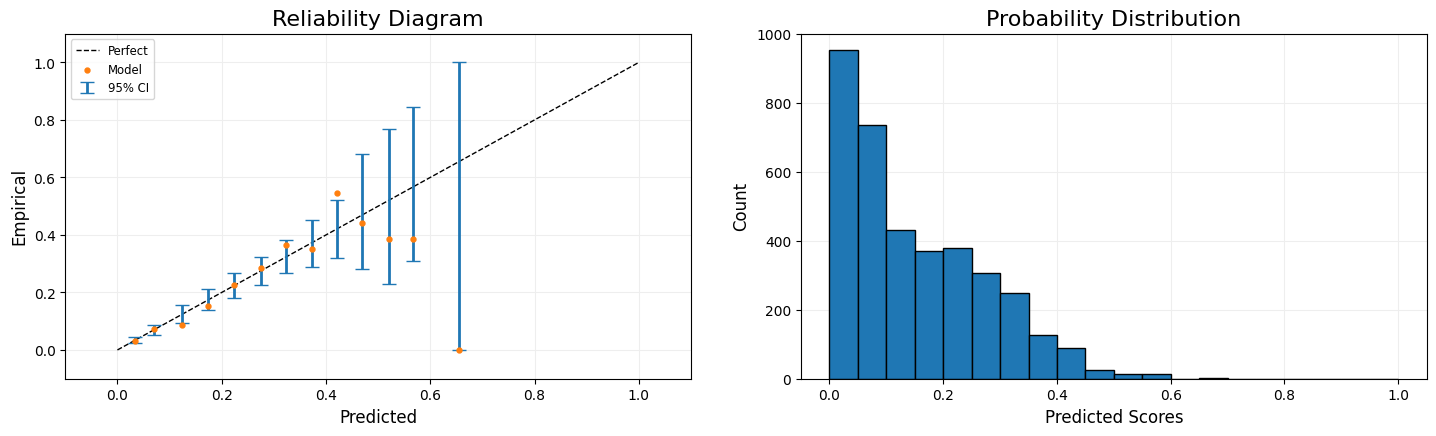

In [62]:
# Realizando predições nos dados de teste
y_pred_uncalibrated = pipe.predict_proba(x_teste)[:,1]

# Plotando informações sobre a calibração
plt.figure(figsize=(15,5))
rd = mli.plot_reliability_diagram(y_teste, y_pred_uncalibrated,show_histogram=True)

## Considerações sobre a calibração
Podemos ver que o nosso modelo possui boas previsões quando temos uma 
probabilidade menor que 50%, mas conforme ela aumenta, o modelo começa a errar
bastante. Portanto, irei calibrar as probabilidades para tentar melhorar o
desempenho do modelo.

### Platt Scaling

In [63]:
# Obtendo as previsões
y_calib_predict = pipe.predict_proba(x_calib)[:,1]

# Treinando o calibrador
platt_calibrator = LogisticRegression(C=99999999999, random_state=200, solver='lbfgs')
platt_calibrator.fit(y_calib_predict.reshape(-1,1), y_calib)

# Obtendo as predições calibradas
platt_probas = platt_calibrator.predict_proba(y_pred_uncalibrated.reshape(-1,1))[:,1]

In [64]:
# Verificando a loss
loss = log_loss(y_teste, platt_probas)
print(f'Loss: {loss}')

Loss: 0.366965008973327


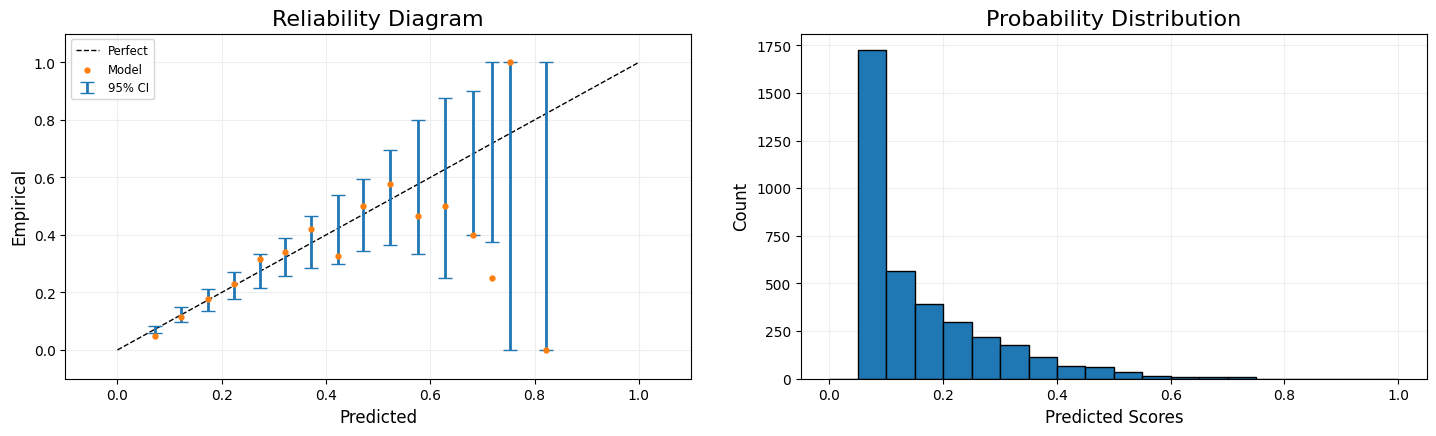

In [65]:
# Plotando informações sobre a calibração
plt.figure(figsize=(15,5))
rd = mli.plot_reliability_diagram(y_teste, platt_probas, show_histogram=True)

### Isotonic Regression

In [66]:
# Obtendo as previsões
y_calib_predict = pipe.predict_proba(x_calib)[:,1]

# Treinando o calibrador
iso_calibrator = IsotonicRegression(out_of_bounds='clip')
iso_calibrator.fit(y_calib_predict.reshape(-1,1), y_calib)

# Obtendo as predições calibradas
iso_probas = iso_calibrator.predict(y_pred_uncalibrated.reshape(-1,1))

In [67]:
# Verificando a loss
loss = log_loss(y_teste, iso_probas)
print(f'Loss: {loss}')

Loss: 0.36464857823536984


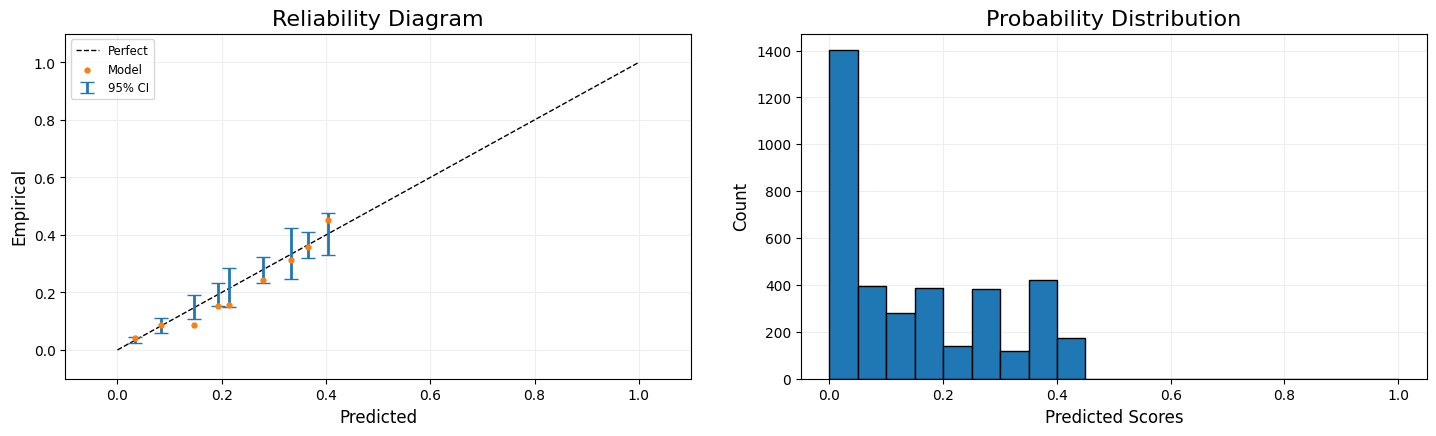

In [68]:
# Plotando informações sobre a calibração
plt.figure(figsize=(15,5))
rd = mli.plot_reliability_diagram(y_teste, iso_probas, show_histogram=True)

### Spline Calibration

In [69]:
# Obtendo as previsões
y_calib_predict = pipe.predict_proba(x_calib)[:,1]

# Treinando o calibrador
spline_calibrator = mli.SplineCalib()
spline_calibrator.fit(y_calib_predict, y_calib)

# Obtendo as predições calibradas
spline_probas = spline_calibrator.predict(y_pred_uncalibrated)

In [70]:
# Verificando a loss
loss = log_loss(y_teste, iso_probas)
print(f'Loss: {loss}')

Loss: 0.36464857823536984


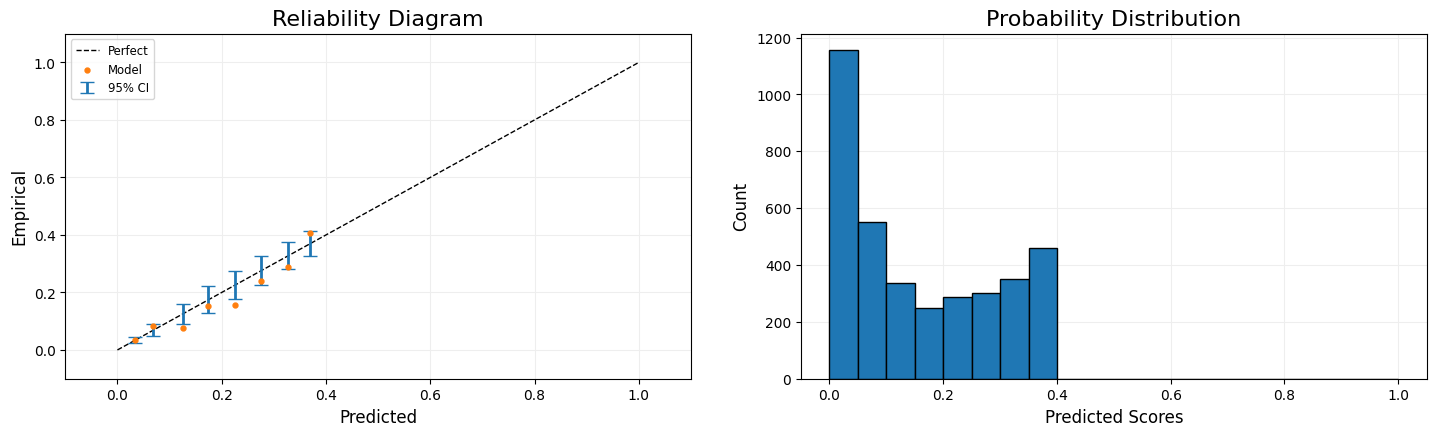

In [71]:
# Plotando informações sobre a calibração
plt.figure(figsize=(15,5))
rd = mli.plot_reliability_diagram(y_teste, spline_probas, show_histogram=True)

## Conclusão da calibração
A partir dos resultados obtidos, podemos observar que a calibração proveniente
da **Spline Calibration** possui intervalos menores e previsões próximas do 
perfeito. Portanto, ela será o calibrador.

## Salvando o modelo e o calibrador

Por fim, irei salvar o modelo e o calibrador para serem usados em produção.

In [72]:
# Salvando o modelo
joblib.dump(pipe, '../models/modelo_final.pkl')

# Salvando o calibrador
joblib.dump(spline_calibrator, '../models/calibrador_final.pkl')

['../models/calibrador_final.pkl']